# Fun With Slope Charts
I continue to explore the different charts from Machine Learning Plus’s [Top 50 matplotlib visualizations](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/) post and look for good opportunities to recreate them with data sets I care about.  Recently, I thought it might be interesting to create a slope chart where I match objects on one side of the chart to objects on the other side.  For my data set, I grabbed CollegeChoice.net's [25 Best Colleges in Ohio](https://www.collegechoice.net/rankings/best-colleges-in-ohio/).  I didn't dig into how they decide one college is *better* than another, although they do provide a description of [their methodology](https://www.collegechoice.net/methodology/).  What I thought was interesting was that they provide the 4-5 most popular majors at each of the colleges.  So, I thought I could create a slope chart where I write the top 10 Ohio Colleges on one side (all 25 would make the chart too cluttered), their most popular majors on the other side, and draw lines in between.  How common are these majors among the top 10?  My chart should be able to tell that story!  Here's what I did:

### Import packages

In [39]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
import math

%matplotlib inline

### Scrape the rankings page from the site

In [5]:
result = requests.get("https://www.collegechoice.net/rankings/best-colleges-in-ohio/")
soup = BeautifulSoup(result.content, 'lxml')

### Use BeautifulSoup to parse top 10 colleges and their most popular majors

In [60]:
ranking_divs = soup.find_all('div', 'ranking-box')
top_10_schools = {}

for ranking_div in ranking_divs[:10]:
    school = ranking_div.select_one('div.rb-list-title h3').text
    majors = [maj.text for maj in ranking_div.select('div.rb-ranking-body ul li')]
    top_10_schools[school] = majors

### Do a little bit of data cleaning

In [61]:
# if we look at a list of the unique majors from the dataset, we see a duplicate major:
# 'Visual & Performing Arts' and 'Visual and Performing Arts'
set(sum(top_10_schools.values(), []))

{'Biology',
 'Biomedical Engineering',
 'Biomedical Sciences',
 'Business & Management',
 'Computer Science',
 'Economics',
 'Education',
 'Engineering',
 'English Language and Literature',
 'Finance',
 'Health Programs',
 'Health Studies',
 'History',
 'International and Global Studies',
 'Management',
 'Marketing',
 'Mechanical Engineering',
 'Molecular Biology',
 'Nursing',
 'Philosophy and Religion',
 'Physical Sciences',
 'Political Science',
 'Psychology',
 'Recreation & Fitness Studies',
 'Social Sciences',
 'Visual & Performing Arts',
 'Visual and Performing Arts'}

In [62]:
# let's standardize that major on 'Visual & Performing Arts'
for school, majors in top_10_schools.items():
    if 'Visual and Performing Arts' in majors:
        top_10_schools[school] = ['Visual & Performing Arts' if maj=='Visual and Performing Arts' else maj for maj in majors]

### Now, let's build the chart

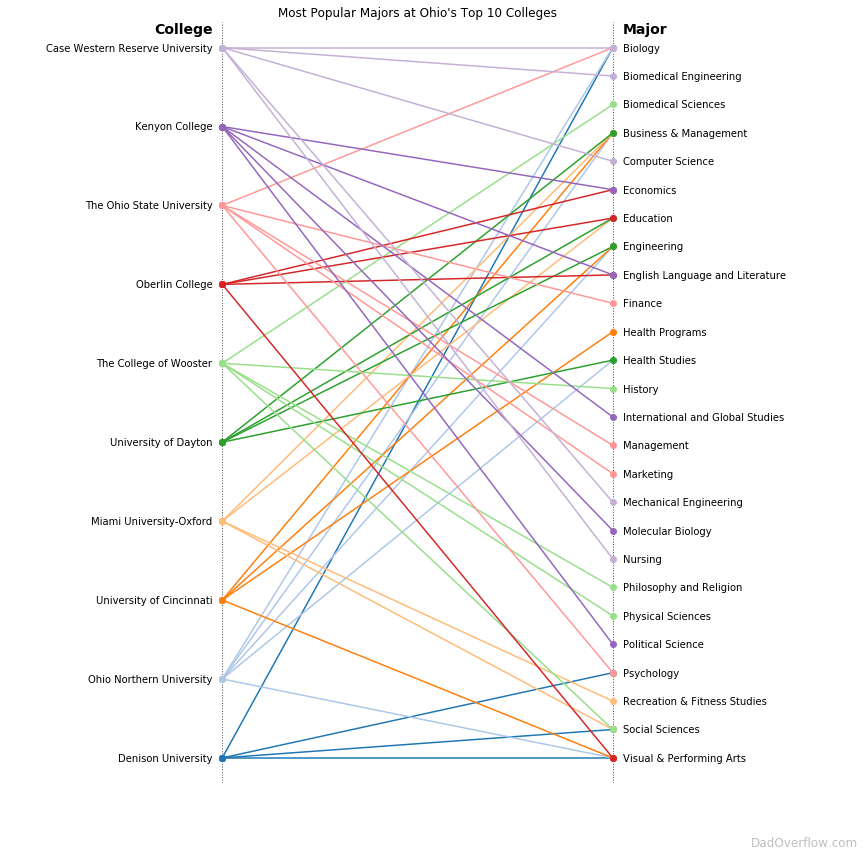

In [66]:
# if, say, you have a count of 11 and you want to round up to the nearest 5, this will return 15
def roundupto(your_count, round_up_to_nearest):
    return int(math.ceil(your_count / round_up_to_nearest)) * round_up_to_nearest

# draws a line between points
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]], color=color, marker='o', markersize=6)
    ax.add_line(l)
    return l
    

fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# get school and major lists and calculate the scale of the chart
school_list = list(top_10_schools.keys())
school_list.reverse()  # matplotlib will then put the #1 school at the top of the chart
major_list = list(set(sum(top_10_schools.values(), [])))
major_list.sort(); major_list.reverse()  # to help matplotlib list majors alphabetically down the chart
scale = roundupto(max(len(school_list), len(major_list)), 5)

# write the vertical lines
ax.vlines(x=1, ymin=0, ymax=scale, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=0, ymax=scale, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# plot the points; unlike the slope chart in the MachineLearningPlus.com article, my Y axis has no meaning, so
# I use numpy's linspace function to help me evenly space each point
school_y_vals = np.linspace(1, scale-1, num=len(school_list))
major_y_vals = np.linspace(1, scale-1, num=len(major_list))
ax.scatter(y=school_y_vals, x=np.repeat(1, len(school_list)), s=10, color='black', alpha=0.7)
ax.scatter(y=major_y_vals, x=np.repeat(3, len(major_list)), s=10, color='black', alpha=0.7)

# write the lines and annotation
for school, school_y_val in zip(school_list, school_y_vals):
    ax.text(1-0.05, school_y_val, school, horizontalalignment='right', verticalalignment='center', fontdict={'size':10})
    for major in top_10_schools[school]:
        major_y_val = major_y_vals[major_list.index(major)]
        newline([1, school_y_val], [3, major_y_val], color=cm.get_cmap('tab20')(school_list.index(school)))
        
for major, major_y_val in zip(major_list, major_y_vals):
    ax.text(3+0.05, major_y_val, major, horizontalalignment='left', verticalalignment='center', fontdict={'size':10})
    
# vertical line annotations
ax.text(1-0.05, scale-0.25, 'College', horizontalalignment='right', verticalalignment='center', 
        fontdict={'size':14, 'weight':700})
ax.text(3+0.05, scale-0.25, 'Major', horizontalalignment='left', verticalalignment='center', 
        fontdict={'size':14, 'weight':700})

# misc cleanup
ax.set(xlim=(0, 4), ylim=(0, scale))
ax.axis('off')

# watermarking my chart
fig.text(0.95, 0.06, 'DadOverflow.com',
         fontsize=12, color='gray',
         ha='right', va='bottom', alpha=0.5)

plt.title("Most Popular Majors at Ohio's Top 10 Colleges")
plt.show()

### What did I learn?
Interestingly, over half of the popular majors are popular at only one of the Top 10 schools.  I expected to see many of the same majors appear repeatedly across multiple schools.  I guess maybe that's a good thing: if, say, you want to study Finance, it would seem The Ohio State University *and only* The Ohio State University is the best place to study the discipline.  